# Save a copy in Drive
Do this first, then proceed.

# Lab 4: Tracking a cricket 
In this lab, we will learn how to estimate the static background of a video and use the result for image subtraction. We will apply this method and blob detection to track the position of the cricket in the videos you collected in class.

Keywords: background subtraction, object detection, blob analysis, insect locomotion 

# Working with video

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv 
import os
from google.colab import files
from google.colab.patches import cv2_imshow # for image display
from skimage import io
import matplotlib.pyplot as plt
import sys

Upload your video using Files menu, then copy its path.

In [ ]:
# Set codec for video
codec = 'mp4v'

# Set max number of frames for background model
ind_max = 1000

# input_vidpath = "paste pathname here"
input_vidpath = "/content/zebrafish_vid.mov"

# Get background model
There are two different background model methods:
`cv.createBackgroundSubtractorMOG2` and `cv.createBackgroundSubtractorKNN`
each have two parameters we can tune to get the background image. If you're not getting the desired result, play with these two parameters or switch the method. 

In [ ]:
# Create background object model 
# The two methods have inputs that we can play with: history, threshold

# bg_model = cv.createBackgroundSubtractorMOG2(history=500, varThreshold = 16)
bg_model = cv.createBackgroundSubtractorKNN(history=800, dist2Threshold=1.0)

## Open video
cap = cv.VideoCapture(input_vidpath)
if not cap.isOpened():
    sys.exit(
        'Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')
    
# Get first frame for setting up output video
ret, frame_init = cap.read()

# iterate through frames to compute background image
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    if not ret:
        break

    # Convert current frame to grayscale
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Extract current frame number
    frame_curr = cap.get(1)

    if ret:
        # Apply background model, returns binary foreground image
        # we can fiddle with the second input or leave empty
        # fgmask = bg_model.apply(frame, 0.6)
        fgmask = bg_model.apply(frame)

        # Get background image
        bg_im = bg_model.getBackgroundImage()

        if cv.waitKey(30) & 0xFF == ord('q'):
            break

    # Save background image and Break loop after max frames
    if frame_curr >= ind_max:
        # Write background image
        cv.imwrite("video_background.png", bg_im)
        break

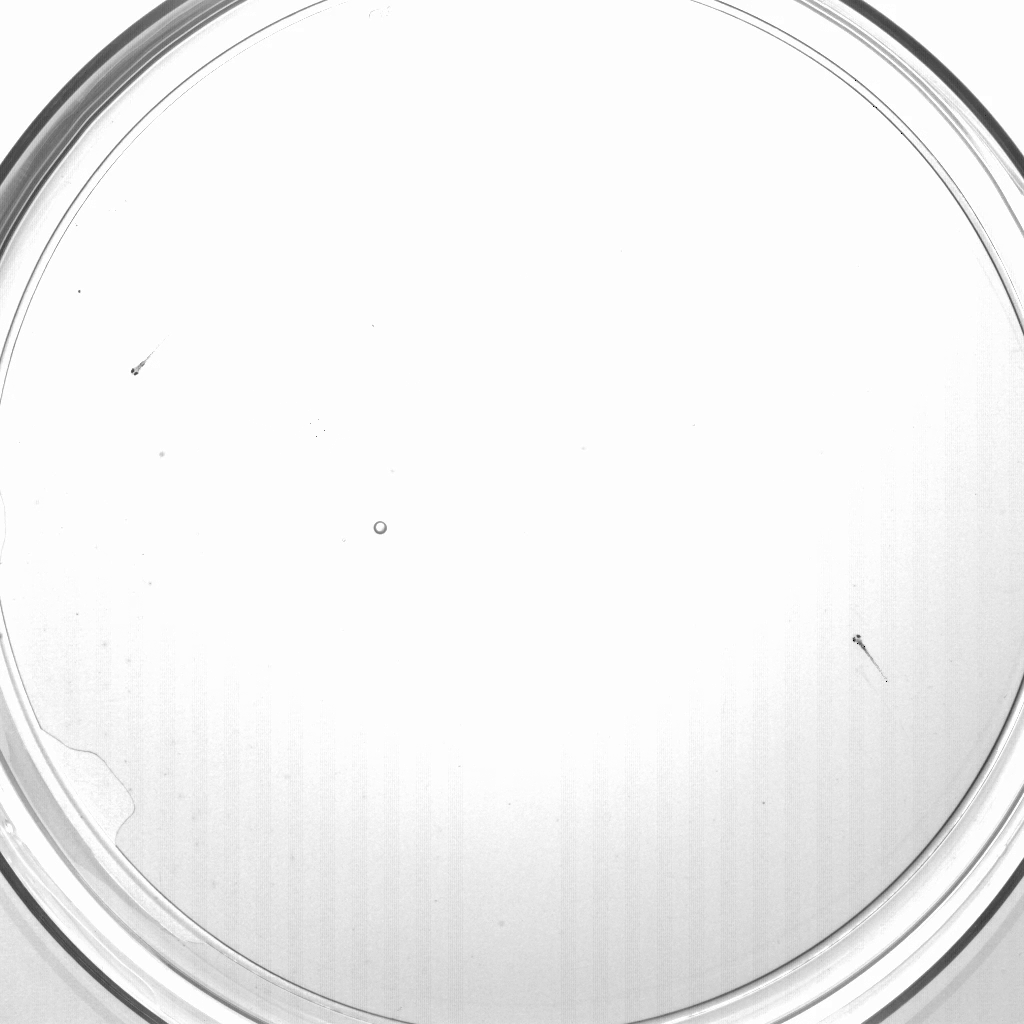

In [ ]:
# Display background image
cv2_imshow(bg_im)

## Background estimate

Is the result useful? 

The ideal background image would have everything that DOES NOT move through the video, but the moving animal should not be visible. If it's not the case, we need to figure out what parameters yield the desired result. 

Another function we can fiddle with:

* `bg_model.apply(frame, learn_rate)` inside the get_background function

Here's [a source](https://stackoverflow.com/questions/43630293/what-are-createbackgroundsubtractorknn-parameters-in-opencv-c) that may help figure out what the parameters mean in the creatBackgroundSubtractor methods. 




# Tracking the object
The code block below iterates through each frame and does the following:


1.   converts to grayscale
2.   performs background subtraction 
3.   smooths image
4.   thresholds to binary image
5.  finds contours and computes it's centroid position coordinates




In [ ]:
# Reset the counter for the video capture object
cap.set(cv.CAP_PROP_POS_FRAMES, 0)

# Initialize variable to break while loop when last frame is achieved
last = 0

xPos = []
yPos = []

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Bail out when the video file ends
    if not ret:
        break

    # Extract current frame number
    this_frame = cap.get(1)

    # Copy of current frame 
    original = frame.copy()

    if ret:
        # Convert current frame to grayscale
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        # Take complement of background
        bg_inv = cv.bitwise_not(bg_im)

        # Background subtraction (by adding inverse of background)
        frame_sub = cv.add(frame, bg_inv)

        # Apply histogram equalization to masked image
        # frame_sub = clahe.apply(frame_sub)

        # Apply smoothing filter
        frame_smooth = cv.bilateralFilter(frame_sub, 5, 40, 40)
        
        # Global thresholding
        frame_binary = cv.threshold(frame_smooth, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
        # thresh = cv2.threshold(frame_smooth, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

        # Get image contours 
        cnts = cv.findContours(frame_binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]

        # Sort contours largest to smallest
        sorted_cnts = sorted(cnts, key=cv.contourArea, reverse=True)
        
        if len(sorted_cnts):

            cnt = sorted_cnts[0]

            M = cv.moments(cnt)

            # Initialize array for object coordinates
            coords = np.array([0, 0])

            if M["m00"] != 0:
              cX = int(M["m10"] / M["m00"])
              cY = int(M["m01"] / M["m00"])
            else:
              cX, cY = 0, 0

            coords = np.array([cX, cY])
            xPos += [cX]
            yPos += [cY]
            
            if cv.waitKey(30) & 0xFF == ord('q'):
              break

    if last >= this_frame:
        break

    last = this_frame

# When everything done, release the capture
cap.release()
cv.destroyAllWindows()
cv.waitKey(1)

NameError: ignored

In [ ]:
# Save contour trajectory to .csv file

df = pd.DataFrame(list(zip(xPos, yPos)), columns = ['xPos', 'yPos'],)

# The frames in which there are >2 contours present are not included
df.index.name = 'Frame'
df.to_csv('animal_trajectory.csv')

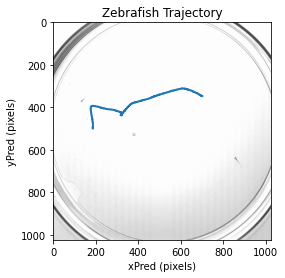

In [ ]:
# Sample plotting cell for debugging

# OpenCV stores images as BGR, but MatPlotLib uses RGB
RGB_img = cv.cvtColor(bg_im, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots()

im = ax.imshow(RGB_img)

ax.plot(xPos, yPos, linewidth=2.0)

plt.title('Animal Trajectory')
plt.ylabel('yPred (pixels)')
plt.xlabel('xPred (pixels)')

plt.savefig('animal_trajectory.png')

plt.show()
